In [2]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

dataset = pd.read_csv('appdata10.csv')

In [3]:
#### EDA ####


dataset.head(10) # Viewing the Data
dataset.describe() # Distribution of Numerical Variables

# First set of Feature cleaning
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

### Plotting
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


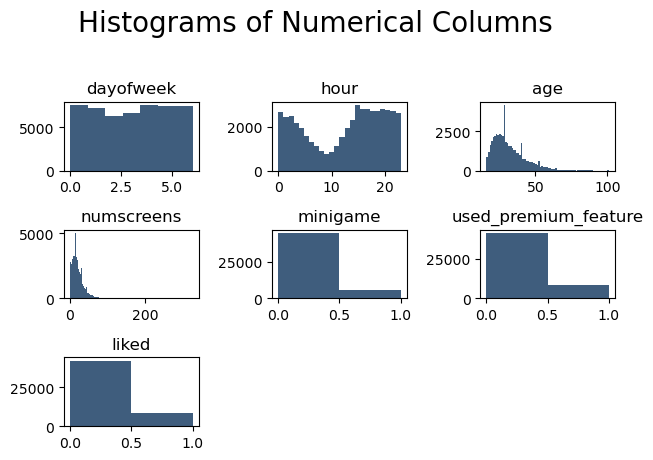

In [4]:
## Histograms
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('app_data_hist.jpg')

<Axes: >

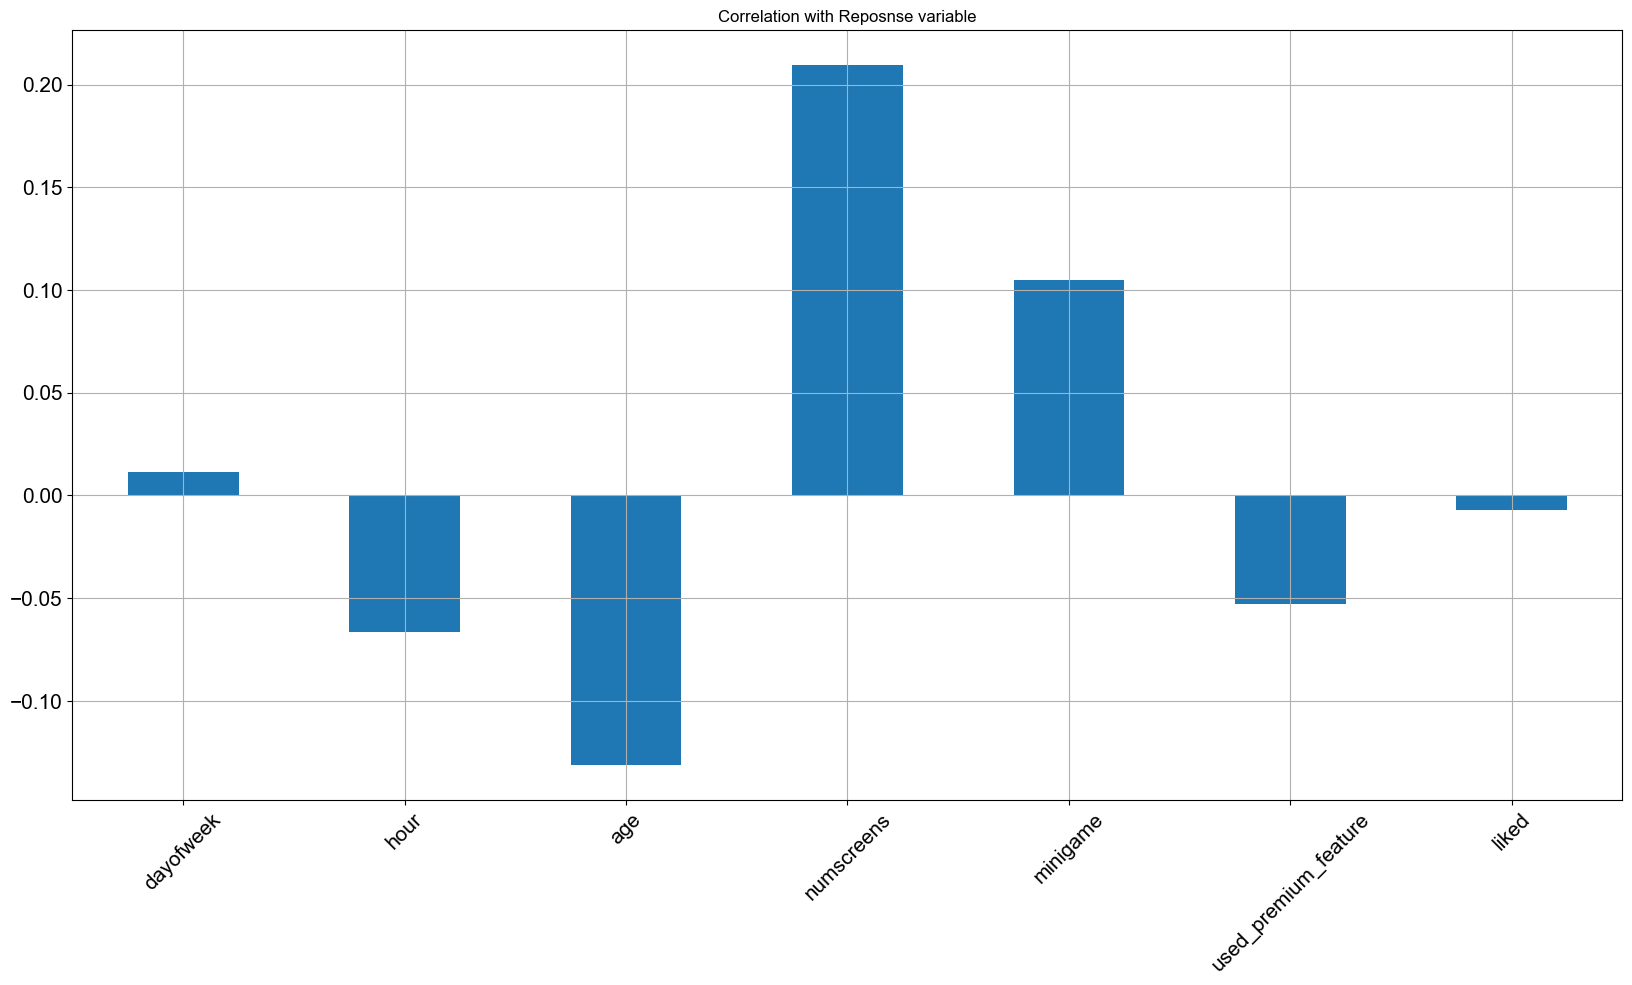

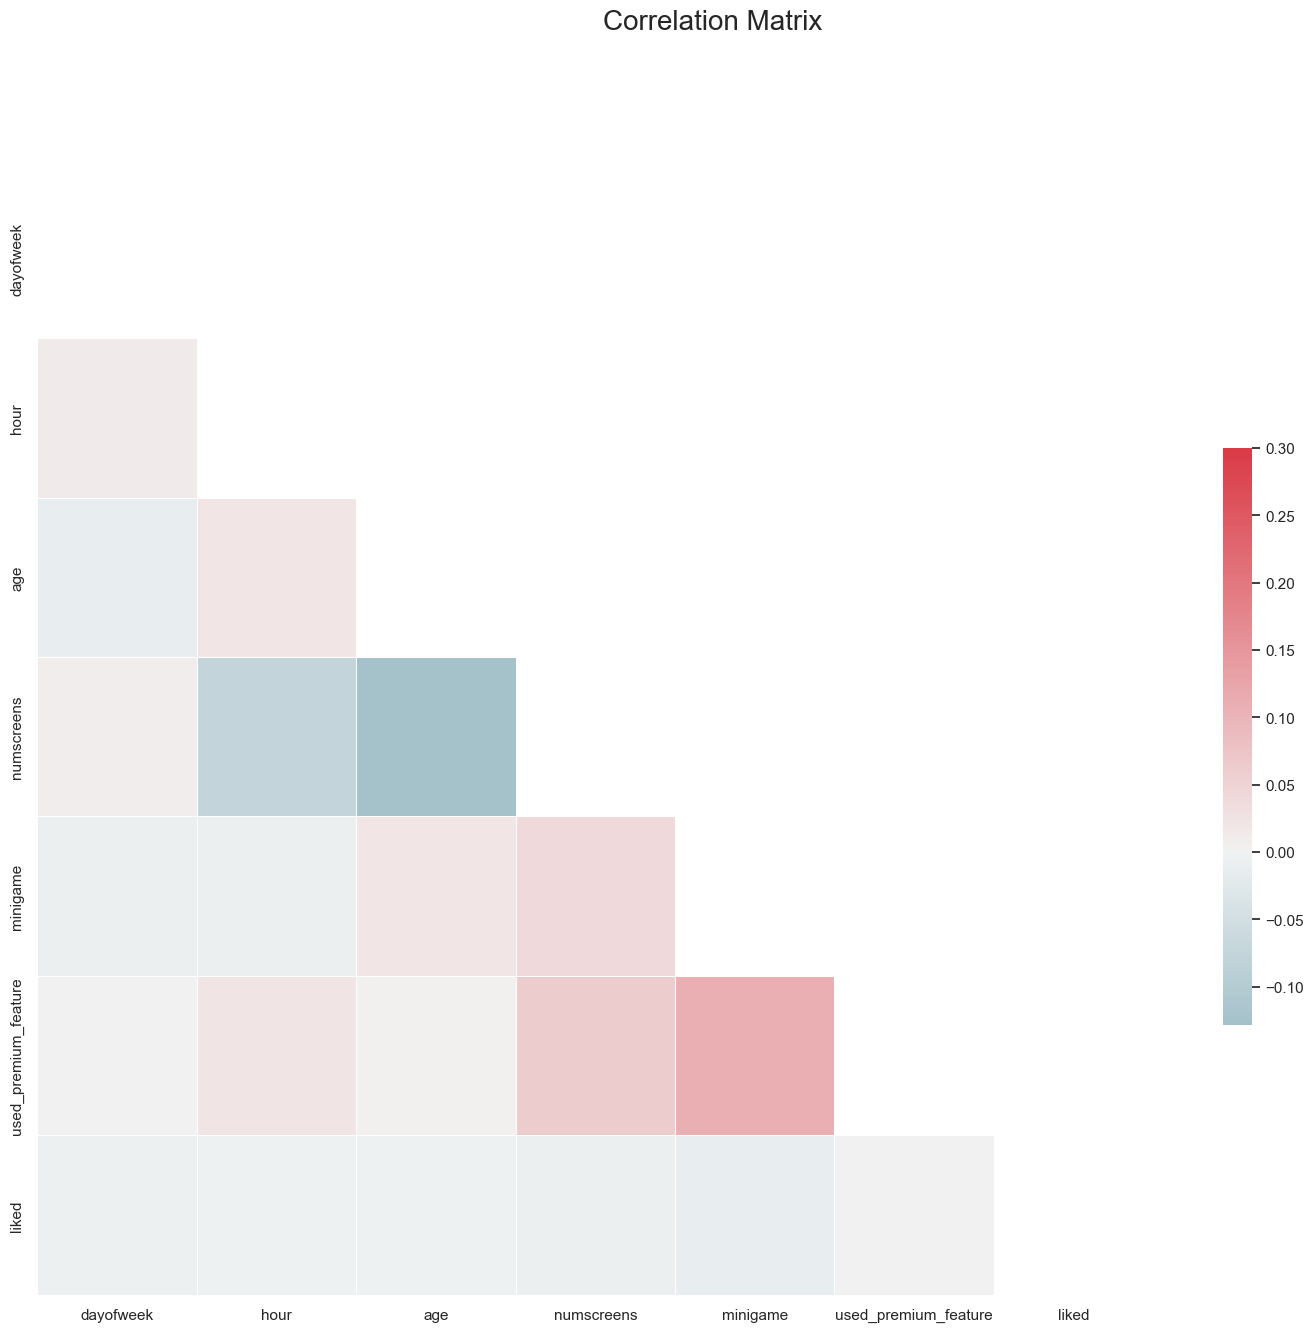

In [5]:
## Correlation with Response Variable
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)


## Correlation Matrix
sn.set(style="white", font_scale=1)

# Compute the correlation matrix
corr = dataset2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 20)

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [6]:
#### Feature Engineering ####


# Formatting Date Columns
dataset.dtypes
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes


user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

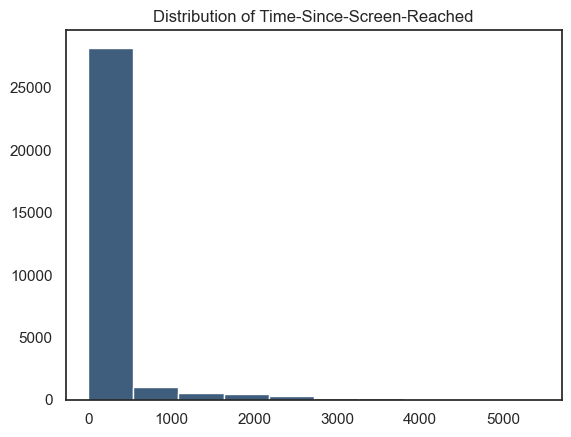

In [7]:
# Selecting Time For Response
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

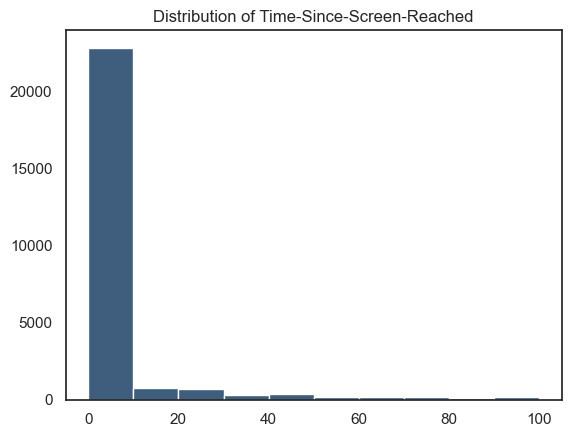

In [8]:
plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()


In [9]:
dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

## Formatting the screen_list Field

# Load Top Screens
top_screens = pd.read_csv('top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [10]:
# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

In [11]:
# Funnels
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [12]:
#### Saving Results ####
dataset.head()
dataset.describe()
dataset.columns

dataset.to_csv('new_appdata10.csv', index = False)

In [13]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time


In [14]:
dataset = pd.read_csv('new_appdata10.csv')


#### Data Pre-Processing ####

# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [15]:
# ## Balancing the Training Set
# import random
# y_train.value_counts()
# #
# pos_index = y_train[y_train.values == 1].index
# neg_index = y_train[y_train.values == 0].index
# #
# if len(pos_index) > len(neg_index):
#     higher = pos_index
#     lower = neg_index
# else:
#     higher = neg_index
#     lower = pos_index
# #
# random.seed(0)
# higher = np.random.choice(higher, size=len(lower))
# lower = np.asarray(lower)
# new_indexes = np.concatenate((lower, higher))
# #
# X_train = X_train.loc[new_indexes,]
# y_train = y_train[new_indexes]


# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2


# 1st MODEL

In [16]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l2')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)

Test Data Accuracy: 0.7680


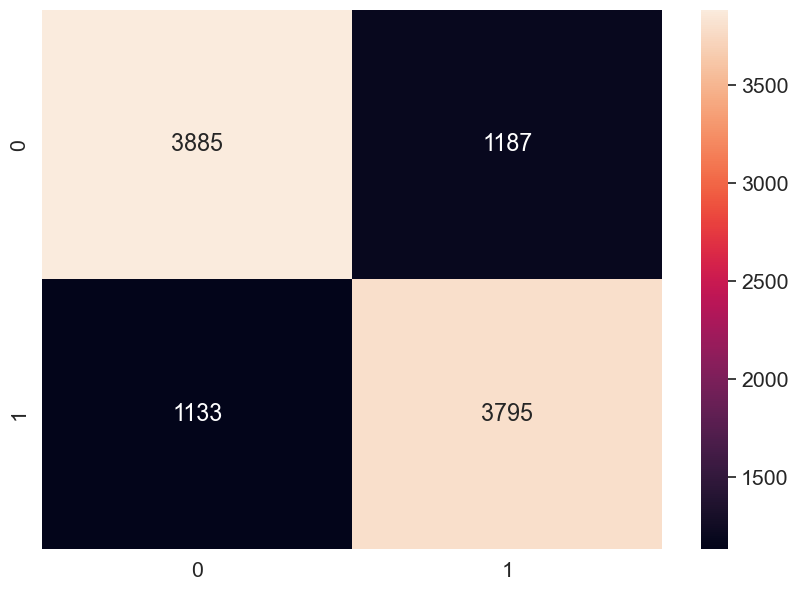

In [17]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# 2nd MODEL


In [18]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

SVM Accuracy: 0.767 (+/- 0.009)


,features,coef
0,dayofweek,0.032715
1,hour,-0.003747
2,age,-0.149793
3,numscreens,-0.131250
4,minigame,-0.026619
5,used_premium_feature,-0.066105
6,liked,0.010852
7,location,-0.028831
8,Institutions,-0.062297
9,VerifyPhone,0.650615


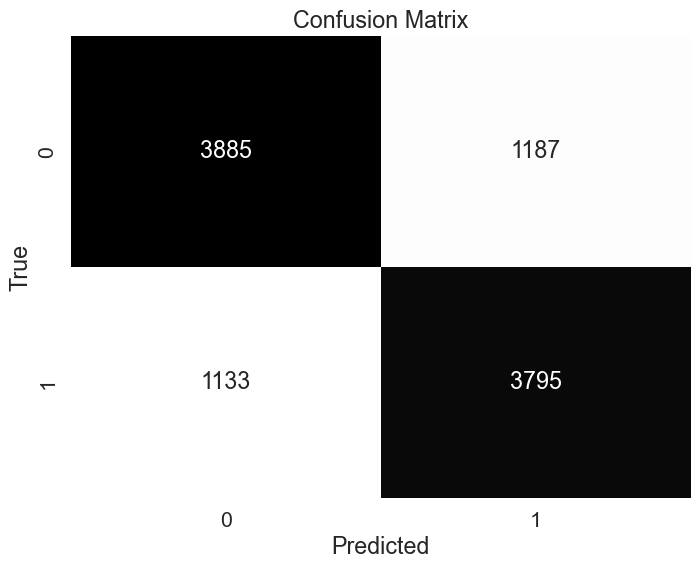

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'classifier' is your SVM model

# Train the SVM model (if not already trained)
classifier.fit(X_train, y_train)

# Predict using the trained model
y_pred_svm = classifier.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#### Model Tuning ####

## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

C:\Users\taran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\linear_model\_l

Took 10.15 seconds


(0.7673249999999999, {'C': 0.01, 'penalty': 'l2'})

In [20]:
## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_


#### End of Model ####


C:\Users\taran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\taran\anaconda3\Lib\site-packages\sklearn\linear_model\_l

Took 7.88 seconds


0.767225

In [21]:
# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)
print(final_results)

        user  enrolled  predicted_reach
0     239786         1                1
1     279644         1                1
2      98290         0                0
3     170150         1                1
4     237568         1                1
...      ...       ...              ...
9995  143036         1                0
9996   91158         1                1
9997  248318         0                0
9998  142418         1                1
9999  279355         1                1

[10000 rows x 3 columns]


# 3rd Model

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2,)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
 
accuracy_score(y_test,y_pred_knn)

# train with Standert Scaling dataset
knn_model2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2,)
knn_model2.fit(X_train, y_train)
y_pred_knn_sc = knn_model2.predict(X_test)
 
ac=accuracy_score(y_test,y_pred_knn_sc)
print("Accuracy Score",ac)

Accuracy Score 0.7314


In [23]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for the original model
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for original model:")
print(conf_matrix)

# Confusion matrix for the model trained with standardized scaling dataset
conf_matrix_sc = confusion_matrix(y_test, y_pred_knn_sc)
print("\nConfusion Matrix for model trained with standardized scaling dataset:")
print(conf_matrix_sc)

Confusion Matrix for original model:
[[3698 1374]
 [1312 3616]]

Confusion Matrix for model trained with standardized scaling dataset:
[[3698 1374]
 [1312 3616]]


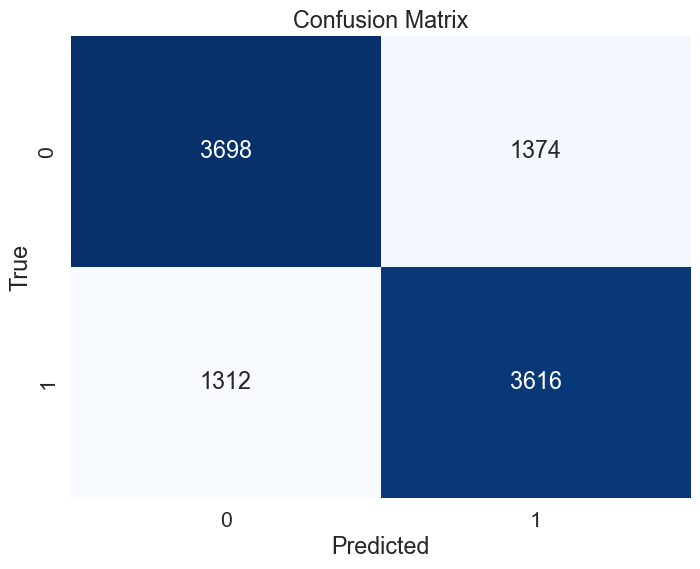

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_knn_sc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()